In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

### *Only run next cell if you want to generate the data from the logs again*

In [44]:
# Get all the trace files
files = glob.glob("../src/benchmarks/*/logs/arg_trace.log")

benchmark_names = [f.split("/")[3] for f in files]

df = pd.DataFrame()
for file in files:
    benchmark_name = file.split("/")[3]
    print(benchmark_name)
    f = open(file, "r")
    file_data = {"call_id": [], "ts": [], "op": [], "args": []}
    # read every line and split it by spaces
    counter = 0
    for line in f:
        if line == '\n': continue
        splitted_line = line.split(" ")
        # First element is in between []
        file_data["ts"].append(splitted_line[0][1:-1])
        # Remove from second element everything that comes after the parenthesis
        file_data["op"].append(splitted_line[1].split("(")[0])

        # For now, put the rest in the arg
        # If parenthesis in the string, add everything that is after the first
        # parenthesis
        if "(" in line:
            file_data["args"].append(line[line.find('('):].strip())
        elif len(splitted_line) > 2:
            file_data["args"].append(" ".join(splitted_line[2:]).strip())
        else:
            raise Exception("Parsing error: ", line)
        
        file_data["call_id"].append(counter)
        counter += 1
        

    file_df = pd.DataFrame(file_data)
    # Multi level indexing, first level is the benchmark name

    file_df["benchmark"] = benchmark_name
    df = pd.concat([df, file_df])

df.set_index(["benchmark", "call_id"], inplace=True)
df.to_pickle("traces.pkl")

latency
hotspot
bfs
yolop
dwt2d
gaussian
myocyte
resnext101
midas
vgg19
resnet50-py
alexnet
resnext50
srad_v1
pathfinder


# Sequence analysis

In [104]:
df = pd.read_pickle("traces.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50525 entries, ('latency', 0) to ('pathfinder', 20)
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ts      50525 non-null  object
 1   op      50525 non-null  object
 2   args    50525 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


In [3]:
# Quickly look at most used operations
df["op"].value_counts()

cudaMemcpy                                     15845
Synchronization                                 8656
cudaLaunchKernel                                7550
cudaMemcpyAsync                                 2499
cudaStreamSynchronize                           2498
cudaThreadSynchronize                           2049
cudnnCreateTensorDescriptor                     1326
cudnnDestroyTensorDescriptor                    1326
cudnnSetTensorNdDescriptor                      1326
cudnnSetConvolutionMathType                      732
cudnnSetStream                                   663
cublasLtMatmulDescSetAttribute                   436
cudnnCreateFilterDescriptor                      366
cudnnSetFilterNdDescriptor                       366
cudnnCreateConvolutionDescriptor                 366
cudnnSetConvolutionNdDescriptor                  366
cudnnSetConvolutionGroupCount                    366
cudnnDestroyConvolutionDescriptor                366
cudnnDestroyFilterDescriptor                  

In [4]:
# Look at the benchmark with the most synchronous calls
df.loc[df["op"] == "Synchronization"].groupby("benchmark").count().sort_values("op", ascending=False)['op']

benchmark
myocyte        7808
yolop           368
srad_v1         225
midas           115
resnext101       51
resnet50-py      44
vgg19            25
alexnet          13
pathfinder        7
Name: op, dtype: int64

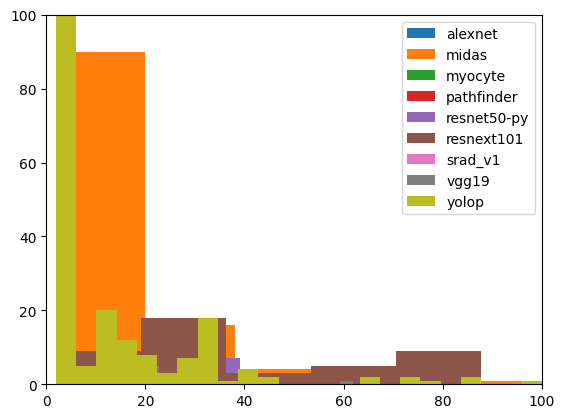

In [5]:
# Look at the distribution of the distance between synchronous calls in the benchmarks
dist = df.loc[df["op"] == "Synchronization"]
dist = dist.reset_index('call_id')['call_id'].diff().dropna()
dist = dist[dist > 0]
for group in dist.groupby("benchmark"):
    group_name = group[0]
    plt.hist(group[1], bins=100, label=group_name)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()

# for benchmark in dist.index.levels[0]:
    # dist.loc[benchmark].plot.hist(bins=100, alpha=0.5, label=benchmark)

In [6]:
# Number of consecutive diff in synchronous calls
dist = df.loc[df["op"] == "Synchronization"]
dist = dist.reset_index('call_id')['call_id'].diff().dropna()
dist = dist[dist > 0]

"Percentage of same consecutive in between synch calls lenght", (dist.diff() == 0).sum() / len(dist)

('Percentage of same consecutive in between synch calls lenght',
 0.03469411356539841)

In [7]:
df

ts               op  \
benchmark  call_id                                         
latency    0        23:31:55:398:398487       cudaMalloc   
           1        23:31:56:617:617045       cudaMemcpy   
           2        23:31:56:617:617084       cudaMemcpy   
hotspot    0        23:30:44:926:926885       cudaMalloc   
           1        23:30:46:112:112985       cudaMalloc   
...                                 ...              ...   
pathfinder 16       12:32:53:078:078479         cudaFree   
           17       12:32:53:078:078710  Synchronization   
           18       12:32:53:078:078720         cudaFree   
           19       12:32:53:078:078733  Synchronization   
           20       12:32:53:078:078737         cudaFree   

                                                                 args  
benchmark  call_id                                                     
latency    0                                        (D0 (0), 4 bytes)  
           1        (cudaMemcpyHostToDevice) D1(0x7f2645600000) <-...  
           2        (cudaMemcpyDeviceToHost, H0(0x7ffeaf8d3554) <-...  
hotspot    0                                   (D0 (0), 100000 bytes)  
           1                                   (D0 (0), 100000 bytes)  
...                                                               ...  
pathfinder 16                             ( devPtr:{0x7ffa32000000} )  
           17                                                      5.  
           18                             ( devPtr:{0x7ffa37600000} )  
           19                                                      6.  
           20                             ( devPtr:{0x7ffa37661c00} )  

[50525 rows x 3 columns]

In [8]:
# Look if they are repetitive patterns with the synch calls as a starting point
unique_operations = df["op"].unique()
op_to_id_map = {op: value for value, op in zip(range(len(unique_operations)), unique_operations)}
df = df.assign(op_id=lambda x: x["op"].map(op_to_id_map))

# Insert nan for sequence
df["sequence"] = np.nan

for benchmark in df.index.levels[0]:
    print(benchmark)
    benchmark_df = df.loc[benchmark]
    pattern_data = {'call_id': [], 'sequence': []}
    sequence = []
    for idx, row in benchmark_df.iterrows():
        if row["op"] == "Synchronization":
            pattern_data['call_id'].append(idx)
            pattern_data['sequence'].append(sequence)
            sequence = []
        else:
            sequence.append(row["op_id"])

    df.loc[(benchmark, pattern_data['call_id']), 'sequence'] = pattern_data['sequence']

alexnet
bfs
dwt2d
gaussian


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

hotspot
latency
midas
myocyte


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

pathfinder
resnet50-py
resnext101


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

resnext50
srad_v1
vgg19
yolop


/home/samrusso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/samrusso/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:924: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


In [9]:
# count the amount of similar sequences in each benchmark
for benchmark in df.index.levels[0]:
    print(benchmark)
    print(df.loc[benchmark, 'sequence'].value_counts())

alexnet
[0, 6, 7, 6, 7]                                                                                                                                                                                                                                                                                     2
[18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                2
[18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                   2
[]                                                                                                            

### Estimating how many times optimistic evaluation would be a thing...

In [10]:
df_sequence = df.dropna(subset=['sequence'])
# One has to reset the index to remove benchmarks with no sequences
df_sequence.reset_index(inplace=True)
df_sequence.set_index(['benchmark', 'call_id'], inplace=True)
df_sequence.index.levels[0].unique()

Index(['alexnet', 'midas', 'myocyte', 'pathfinder', 'resnet50-py',
       'resnext101', 'srad_v1', 'vgg19', 'yolop'],
      dtype='object', name='benchmark')

In [76]:
data_1 = {'benchmark': [], 'sequence': [], 'count': [], 'call_id': []}
data_2 = {'benchmark': [], 'sequence': [], 'count': [], 'call_id': []}
data_3 = {'benchmark': [], 'sequence': [], 'count': [], 'call_id': []}
for benchmark in df_sequence.index.levels[0]:
    print(benchmark)
    sequence_1 = None
    sequence_2 = None
    sequence_3 = None
    count_1 = 0
    count_2 = 0
    count_3 = 0

    for row in df_sequence.loc[benchmark].itertuples():
        sequence = row.sequence
        call_id = row.Index
        if sequence == sequence_1:
            count_1 += 1
        elif count_1 > 0:
            data_1['benchmark'].append(benchmark)
            data_1['sequence'].append(sequence_1)
            data_1['count'].append(count_1)
            data_1['call_id'].append(call_id)
            # print(sequence, count)
            count_1 = 0
        if sequence == sequence_2:
            count_2 += 1
        elif count_2 > 0:
            data_2['benchmark'].append(benchmark)
            data_2['sequence'].append(sequence_2)
            data_2['count'].append(count_2)
            data_2['call_id'].append(call_id)
            # print(sequence, count)
            count_2 = 0
        if sequence == sequence_3:
            count_3 += 1
        elif count_3 > 0:
            data_3['benchmark'].append(benchmark)
            data_3['sequence'].append(sequence_3)
            data_3['count'].append(count_3)
            data_3['call_id'].append(call_id)
            # print(sequence, count)
            count_3 = 0

        sequence_3 = sequence_2
        sequence_2 = sequence_1
        sequence_1 = sequence

df_1 = pd.DataFrame(data_1)
df_1['pattern'] = 1
df_2 = pd.DataFrame(data_2)
df_2['pattern'] = 2
df_3 = pd.DataFrame(data_3)
df_3['pattern'] = 3
optimistic_df = pd.concat([df_1, df_2, df_3])
optimistic_df.set_index(['benchmark', 'pattern'], inplace=True)

alexnet
midas
myocyte
pathfinder
resnet50-py
resnext101
srad_v1
vgg19
yolop


In [12]:
# Percentage among all synch calls that would benefit from being optimistically executed
print("Percentage among all synch sequences that would benefit from being directly repeating i-th last sequence")
for i in range(1,4):
    print(i, ":", optimistic_df.xs(i, level=1)['count'].sum() / df.loc[df["op"] == "Synchronization"].shape[0]*100, "%")



Percentage among all synch sequences that would benefit from being directly repeating i-th last sequence
1 : 2.114140480591497 %
2 : 94.29297597042515 %
3 : 2.634011090573013 %


In [78]:
optimistic_df

sequence  count  \
benchmark pattern                                                             
alexnet   1                                          [0, 6, 7, 6, 7]      1   
          1        [18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 2, 9, 1...      1   
          1        [18, 19, 17, 20, 21, 22, 23, 23, 2, 2, 9, 10, ...      1   
midas     1        [18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 12...      2   
myocyte   1                                                      [0]      2   
...                                                              ...    ...   
yolop     3        [0, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, ...      1   
          3        [0, 2, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 1...      1   
          3        [18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10...      1   
          3                                                   [6, 7]     39   
          3                                                   [6, 7]     93   

                   call_id  
benchmark pattern           
alexnet   1             58  
          1            126  
          1            223  
midas     1           3428  
myocyte   1             11  
...                    ...  
yolop     3           2600  
          3           2976  
          3           3543  
          3           4368  
          3           4707  

[90 rows x 3 columns]

In [14]:
# Percentage among all synch calls that would benefit from being optimistically executed for each benchmark
synch_tot = df.loc[df["op"] == "Synchronization"].groupby("benchmark").count()
print(synch_tot.loc['alexnet']['op'])
for benchmark in optimistic_df.index.levels[0]:
    print(benchmark)
    for i in optimistic_df.index.levels[1]:
        try:
            print(i, ":", (optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']) * 100, "%")
        except KeyError: 
            pass # This happens when they are not such patterns in the benchmark

13
alexnet
1 : 23.076923076923077 %
midas
1 : 1.7391304347826086 %
2 : 5.217391304347826 %
3 : 59.130434782608695 %
myocyte
1 : 0.038422131147540985 %


/tmp/ipykernel_1130/59046860.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(i, ":", (optimistic_df.xs((benchmark, i))['count'].sum() / synch_tot.loc[benchmark]['op']) * 100, "%")


2 : 99.8719262295082 %
3 : 0.012807377049180328 %
resnet50-py
1 : 20.454545454545457 %
2 : 9.090909090909092 %
3 : 18.181818181818183 %
resnext101
1 : 17.647058823529413 %
2 : 5.88235294117647 %
3 : 5.88235294117647 %
srad_v1
1 : 3.5555555555555554 %
2 : 90.66666666666666 %
3 : 1.7777777777777777 %
vgg19
1 : 20.0 %
2 : 20.0 %
3 : 4.0 %
yolop
1 : 39.130434782608695 %
2 : 38.58695652173913 %
3 : 38.858695652173914 %


# Argument analysis

In [83]:
# Look at the most common sequence in resnet50-py
optimistic_df.loc['resnet50-py', 'sequence'].value_counts()

/tmp/ipykernel_1130/608067606.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  optimistic_df.loc['resnet50-py', 'sequence'].value_counts()


[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7]                                                                                                                                                                                                                                                                                             4
[18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10, 11, 24, 23, 23, 2, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                                                                                                                                                                                                               3
[18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10, 11, 24, 23, 23, 9, 10, 11, 12, 13, 10, 11, 14, 15, 16, 17]                                                                                                  

In [37]:
sequence = optimistic_df.loc['resnet50-py', 'sequence'].value_counts().index[0]
# map sequence to operations
sequence = [unique_operations[op_id] for op_id in sequence]
print(sequence)

['cudaMalloc', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize', 'cudaMemcpyAsync', 'cudaStreamSynchronize']


/tmp/ipykernel_1130/401038607.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sequence = optimistic_df.loc['resnet50-py', 'sequence'].value_counts().index[0]


In [81]:
# Look at the arguments of the most common sequence in resnet50-py

# df_sequence.loc['resnet50-py', 'sequence']
optimistic_df.loc['resnet50-py', ('sequence', 'call_id')]

,sequence,call_id
pattern,,
1,"[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...",312
1,"[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...",554
1,"[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...",618
1,"[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...",686
1,"[18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10...",1082
1,"[18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10...",1441
1,"[18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10...",1958
2,"[0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...",554
2,"[18, 19, 17, 20, 21, 22, 23, 23, 9, 10, 11, 10...",1413


In [88]:
end_synch = df.loc[('resnet50-py', 312)]
seq_len = len(end_synch['sequence'])
start_synch_id = 312 - seq_len

In [17]:
df_sequence

ts               op args  op_id  \
benchmark  call_id                                                     
yolop      0        12:58:25:439:439598  Synchronization   0.      4   
           2        12:58:25:482:482549  Synchronization   1.      4   
           212      12:58:25:485:485651  Synchronization   2.      4   
           276      12:58:25:487:487212  Synchronization   3.      4   
           350      12:58:25:490:490513  Synchronization   4.      4   
...                                 ...              ...  ...    ...   
pathfinder 5        12:32:53:030:030762  Synchronization   2.      4   
           13       12:32:53:077:077638  Synchronization   3.      4   
           15       12:32:53:078:078464  Synchronization   4.      4   
           17       12:32:53:078:078710  Synchronization   5.      4   
           19       12:32:53:078:078733  Synchronization   6.      4   

                                                             sequence  
benchmark  call_id                                                     
yolop      0                                                       []  
           2                                                      [5]  
           212      [0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...  
           276      [0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...  
           350      [0, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, ...  
...                                                               ...  
pathfinder 5                                                   [0, 1]  
           13                                   [0, 1, 2, 2, 2, 2, 2]  
           15                                                     [1]  
           17                                                     [3]  
           19                                                     [3]  

[8656 rows x 5 columns]

In [75]:
for row in df_sequence.xs('yolop').itertuples():
    print(row.Index)

0
2
212
276
350
392
490
618
692
1102
1107
1121
1124
1132
1142
1145
1148
1151
1165
1183
1199
1218
1233
1253
1267
1306
1335
1348
1351
1382
1414
1417
1448
1480
1675
1707
1739
1756
1760
1775
1784
1795
1799
1813
1830
1834
1856
1867
1871
1899
1903
1925
1936
1940
1968
1972
1994
2034
2066
2084
2088
2102
2125
2140
2149
2160
2164
2207
2239
2304
2317
2334
2338
2384
2393
2404
2408
2436
2440
2461
2472
2476
2563
2579
2583
2600
2763
2766
2783
2787
2817
2821
2849
2853
2874
2885
2889
2976
3120
3148
3159
3163
3177
3211
3245
3280
3313
3447
3478
3511
3543
3575
3607
3683
3716
3852
3892
3914
4153
4184
4196
4199
4212
4217
4220
4223
4226
4229
4232
4235
4238
4241
4244
4247
4250
4253
4256
4259
4262
4265
4268
4271
4274
4277
4280
4283
4286
4289
4292
4295
4298
4301
4304
4307
4310
4313
4316
4319
4322
4325
4328
4331
4334
4337
4340
4343
4368
4381
4386
4390
4394
4397
4400
4403
4406
4409
4412
4415
4418
4421
4424
4427
4430
4433
4436
4439
4442
4445
4448
4451
4454
4457
4460
4463
4466
4469
4472
4475
4478
4481
4484
4487
449

# Direct reduction of synch calls analysis

In [160]:
def count_calls(df, op):
    return df.loc[df["op"] == op].groupby("benchmark").count()['op']

def remove_synch_calls(df, op):
    # Remove from the df the synch calls that appear just before the op
    synch_calls = df.loc[df["op"] == "Synchronization"]    
    op_calls = df.loc[df["op"] == op]

    # One has to reset the index to remove benchmarks with no op/synch calls
    synch_calls = synch_calls.reset_index()
    synch_calls = synch_calls.set_index(['benchmark', 'call_id'])

    op_calls = op_calls.reset_index()
    op_calls = op_calls.set_index(['benchmark', 'call_id'])

    drop_index = []
    drop_counts = {key: 0 for key in df.index.levels[0]}

    for benchmark in synch_calls.index.levels[0].intersection(op_calls.index.levels[0]):
        drop_count = 0 
        for op_call_id in op_calls.loc[benchmark].index:
            # Check if there is a synch call just before the op call
            if op_call_id - 1 in synch_calls.loc[benchmark].index:
                drop_index.append((benchmark, op_call_id - 1))
                drop_count += 1
        drop_counts[benchmark] = drop_count
    return df.drop(drop_index), drop_counts

def percentage_removed_sync_calls(df, op):
    _, synch_count = remove_synch_calls(df, op)
    removed_synch_percentage = {}
    for benchmark in synch_count.keys():
        total = df.xs(benchmark, level=0)
        total = total.loc[total["op"] == "Synchronization"].shape[0]
        if total > 0:
            removed_synch_percentage[benchmark] = synch_count[benchmark] / total
        else:
            removed_synch_percentage[benchmark] = 0
    return removed_synch_percentage

def percentage_removed_sync_calls_array(df, op_array):
    removed_synch_percentage = {}
    for benchmark in df.index.levels[0]:
        count = 0
        for op in op_array:
            _, synch_count = remove_synch_calls(df, op)
            count += synch_count[benchmark]
        total = df.xs(benchmark, level=0)
        total = total.loc[total["op"] == "Synchronization"].shape[0]
        if total > 0:
            removed_synch_percentage[benchmark] = count / total
    return removed_synch_percentage


   

## Reduction of synch at every cudaMalloc, cudaFree, *_v7 calls

In [146]:
df_no_cudaMalloc_synch, cudaMalloc_removed_synch_count = remove_synch_calls(df, "cudaMalloc")
df_no_cudaFree_synch, cudaFree_removed_synch_count = remove_synch_calls(df, "cudaFree")
cudaMalloc_removed_synch_count, cudaFree_removed_synch_count

({'alexnet': 5,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 92,
  'myocyte': 4,
  'pathfinder': 3,
  'resnet50-py': 18,
  'resnext101': 29,
  'resnext50': 0,
  'srad_v1': 12,
  'vgg19': 13,
  'yolop': 81},
 {'alexnet': 0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0,
  'myocyte': 4,
  'pathfinder': 3,
  'resnet50-py': 0,
  'resnext101': 0,
  'resnext50': 0,
  'srad_v1': 12,
  'vgg19': 0,
  'yolop': 0})

In [153]:
# percentage of synch calls that are removed
cudaMalloc_removed_synch_percentage = percentage_removed_sync_calls(df, "cudaMalloc")
cudaFree_removed_synch_percentage = percentage_removed_sync_calls(df, "cudaFree")
cudaMalloc_removed_synch_percentage, cudaFree_removed_synch_percentage

({'alexnet': 0.38461538461538464,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.8,
  'myocyte': 0.0005122950819672131,
  'pathfinder': 0.42857142857142855,
  'resnet50-py': 0.4090909090909091,
  'resnext101': 0.5686274509803921,
  'resnext50': 0,
  'srad_v1': 0.05333333333333334,
  'vgg19': 0.52,
  'yolop': 0.22010869565217392},
 {'alexnet': 0.0,
  'bfs': 0,
  'dwt2d': 0,
  'gaussian': 0,
  'hotspot': 0,
  'latency': 0,
  'midas': 0.0,
  'myocyte': 0.0005122950819672131,
  'pathfinder': 0.42857142857142855,
  'resnet50-py': 0.0,
  'resnext101': 0.0,
  'resnext50': 0,
  'srad_v1': 0.05333333333333334,
  'vgg19': 0.0,
  'yolop': 0.0})

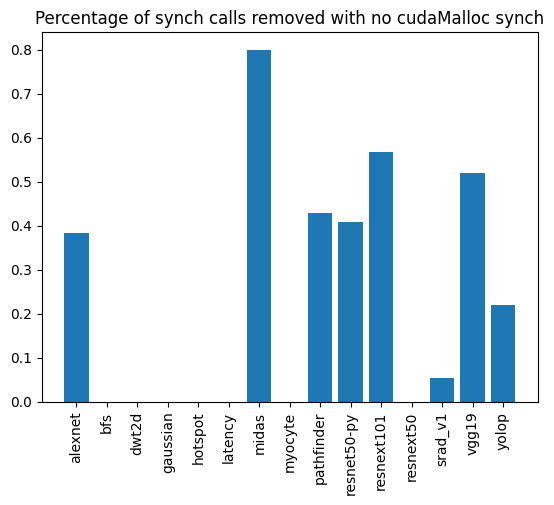

dict_keys(['alexnet', 'bfs', 'dwt2d', 'gaussian', 'hotspot', 'latency', 'midas', 'myocyte', 'pathfinder', 'resnet50-py', 'resnext101', 'resnext50', 'srad_v1', 'vgg19', 'yolop'])

In [164]:
plt.title("Percentage of synch calls removed with no cudaMalloc synch")
values = list(cudaMalloc_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(cudaMalloc_removed_synch_percentage.keys()), rotation=90)
plt.show()
cudaMalloc_removed_synch_percentage.keys()

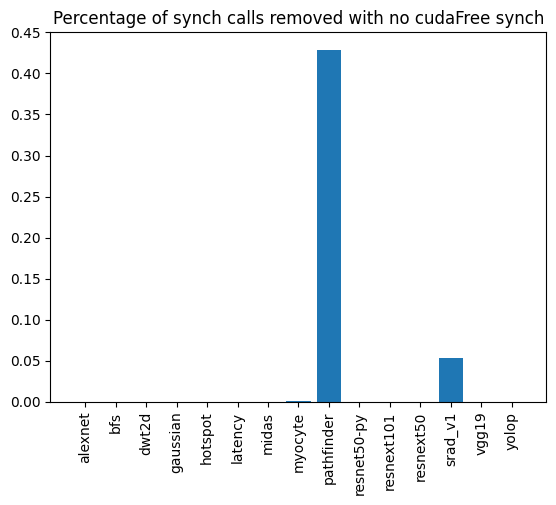

In [154]:
plt.title("Percentage of synch calls removed with no cudaFree synch")
values = list(cudaFree_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(cudaFree_removed_synch_percentage.keys()), rotation=90)
plt.show()

## Reduction of synch at every *_v7 calls

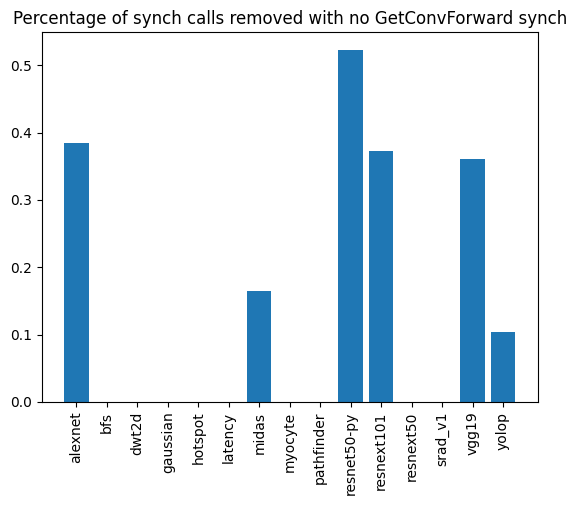

In [155]:
forward_removed_synch_percentage = percentage_removed_sync_calls(df, "cudnnGetConvolutionForwardAlgorithm_v7")

plt.title("Percentage of synch calls removed with no GetConvForward synch")
values = list(forward_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(forward_removed_synch_percentage.keys()), rotation=90)
plt.show()

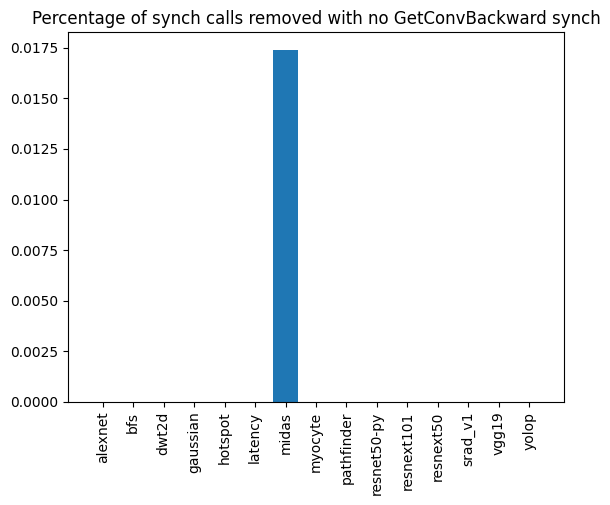

In [156]:
backward_removed_synch_percentage = percentage_removed_sync_calls(df, "cudnnGetConvolutionBackwardDataAlgorithm_v7")

plt.title("Percentage of synch calls removed with no GetConvBackward synch")
values = list(backward_removed_synch_percentage.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(backward_removed_synch_percentage.keys()), rotation=90)
plt.show()

## Total reduction of synch calls

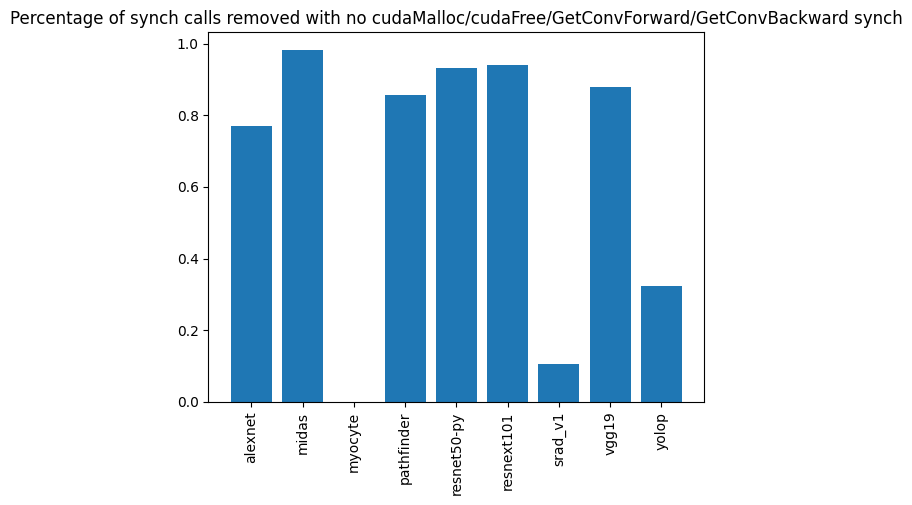

In [163]:
total_percentage_removed = percentage_removed_sync_calls_array(df, ["cudaMalloc", "cudaFree", "cudnnGetConvolutionForwardAlgorithm_v7", "cudnnGetConvolutionBackwardDataAlgorithm_v7"])

plt.title("Percentage of synch calls removed with no cudaMalloc/cudaFree/GetConvForward/GetConvBackward synch")
values = list(total_percentage_removed.values())
x = np.arange(len(values))
plt.bar(x, values)
plt.xticks(x, list(total_percentage_removed.keys()), rotation=90)
plt.show()